In this notebook, we use the Myers-Briggs Personality Type Dataset for classification of users into 16 distinct MBTI Personaltiy types. There are 4 indicators for each peronality type:

    1) Introversion (I) – Extroversion (E)
    2) Intuition (N) – Sensing (S)
    3) Thinking (T) – Feeling (F)
    4) Judging (J) – Perceiving (P)

Thus it can be seen that the problem statement can be divised as either a multiclass classification or multilabel classification.

    Multiclass --> Each label is an integer L between 0-N, where N is number of classes.
    Multilabel --> Each label is a set of four different sublabels --> L1, L2, L3, L4,
                and each L is an integer between 0 & 1.

Since our data is heavily imbalanced, we'll be using a Random Balanced Sampler, which samples examples from uncommon classes much more often, so as to maintain the frequency of samples across all classes.
                
- In this problem statement, we'll be looking at several metrics like accuracy, recall, etc. But we'll be using and following the F1-Score for comparing different models. This is because F1-Score is a good measure to balance both recall and precision of the model. And since F1-Score is more sensitive to class distributions, it is used for handling imbalanced classes, as is our case.

- More specifically, we'll be focusing on Macro F1-Score, which is the average of F1-Score computed over the individual classes. It gives an exact sense of bias wrt the uncommon classes, and how well the system will perform in a real world scenario, where the distribution of the dataset might not reflect on the actual scenario.

Additionally, we use Stratified 5-Fold Validation, which maintains the ratio between classes for every split. A random_state of 42 is used (wherever availbable), to make the results replicable.

1) Firstly we proceed with multiclass dataset with 16 classes. We get the data, clean it, like remove all hyperlinks and unwanted characters. Then proceed to vectorize the data based on TF-IDF.

2) Then we train several models, tune the hyperparameters using GridSearchCV (done previously in another notebook), and perform Cross Validation (if possible). Finally the best classifiers are chosen to create and ensemble classifier and tested against the test dataset.

3) This process is repeated, firstly for multiclass labels, secondly for multilabel classification, and finally for PCA Decompostion on feature sets with multilabel classification.

In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings("ignore")

In [512]:
data = pd.read_csv('./mbti_1.csv')

# Multiclass Classification

In [553]:
from sklearn.preprocessing import LabelEncoder

# Encoding labels in 0->16 (cardinality=16) format.
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)

In [535]:
def pre_process_data(data):
    list_personality = []
    list_posts = []
    len_data = len(data)
    
    for row in tqdm(data.iterrows()):
        
        st = row[1].posts
        
        st = st.lower()
        st = re.sub(r'\|{3}',' ',st) # split each post
        st = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',st) # remove hyperlinks
        st = re.sub('[\'\/]', '',st) # form a single word for words like you're and it's
        st = re.sub('[^\w]',' ',st) # remove anything other than a word char
        st = re.sub(r'\s{1,}',' ',st) # remove multiple spaces
        st = re.sub(r'^\s|\s$', '', st) # remove start and end whitespaces

        type_labelized = lab_encoder.transform([row[1].type])[0] # encoding labels
        list_personality.append(type_labelized)
        list_posts.append(st)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality = pre_process_data(data)

8675it [00:14, 592.17it/s]


In [536]:
from sklearn.model_selection import train_test_split
train_post, test_post, train_type, test_type = train_test_split(list_posts, list_personality, test_size = 0.2,
                                                                random_state = 42, stratify = list_personality)

    Using Tf-idf instead of count vectorizer, because it is more informative as well as representative of the data. Selecting words with 10% > document freq < 50%, and not more than 1500 words. The parameters may be adjusted, which might lead to giving different, maybe improved scores.
    
    The resuting feature set is of 796d size, which is a large feature set.
    
    However, the information density in these feature sets is very low. We will either have to increase the amount of information, or decrease the dimensions.

In [545]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer="word", max_features=1500, max_df=0.5, min_df=0.1)
X_train = vectorizer.fit_transform(train_post).toarray() # fitting to the training data posts
X_test = vectorizer.transform(test_post).toarray()
Y_train = train_type
Y_test = test_type

In [546]:
print(X_train.shape, type(X_train), Y_train.shape, type(Y_train))

(6940, 796) <class 'numpy.ndarray'> (6940,) <class 'numpy.ndarray'>


In [19]:
def fit_metrics(Y_test, Y_pred):
    # Returns a dict of scores.
    accuracy_score, precision_score, recall_score, f1_score
    keys = ["accuracy", "precision", "recall", "f1"]
    avgs = ["micro", "macro", "weighted"]
    scores = {}
    scores[keys[0]] = accuracy_score(Y_test, Y_pred)
    for i in range(1,4):
        for j in range(3):
            if i == 1:
                scores[keys[i]+"_"+avgs[j]] = precision_score(Y_test, Y_pred, average=avgs[j])
            elif i == 2:
                scores[keys[i]+"_"+avgs[j]] = recall_score(Y_test, Y_pred, average=avgs[j])
            elif i == 3:
                scores[keys[i]+"_"+avgs[j]] = f1_score(Y_test, Y_pred, average=avgs[j])
    return scores

In [128]:
def fit_model(model_uninst, X, Y, model_params=None, multilabel=False, verbose=True):
    """
    Custom fit module, with Stratified K Fold Cross Validation, and accomodating both
    multi-class and multi-label data.
    Multiclass --> Each label is an integer L between 0-N, where N is number of classes.
    Multilabel --> Each label is a set of four different sublabels --> L1, L2, L3, L4
                    and each L is an integer [0,1]
    """
    
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    i = 0
    scores = []
    for train_index, test_index in skf.split(X, Y):
        i += 1
        if model_params is not None:
            model = model_uninst(**model_params)
        else:
            model = model_uninst()
        
        if multilabel:
            model = MultiOutputClassifier(model)
        
        X_train_fold, Y_train_fold = X[train_index], Y[train_index]
        X_test_fold, Y_test_fold = X[test_index], Y[test_index]
        
        ros = RandomOverSampler(random_state=42)
        X_train_re, Y_train_re = ros.fit_resample(X_train_fold, Y_train_fold)
        
        model.fit(X_train_re, Y_train_re)
        Y_pred_fold = model.predict(X_test_fold)
        scores.append(fit_metrics(Y_test_fold, Y_pred_fold))
        
        if verbose:
            print("[CV %d/5] Model Validation Accuracy: %.4f" %(i, scores[-1]["accuracy"]))
        
    return scores

# Multinomial Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB

In [53]:
mnbcls = MultinomialNB
scores = fit_model(mnbcls, X_train, Y_train)

[CV 1/5] Model Validation Accuracy: 0.5461
[CV 2/5] Model Validation Accuracy: 0.5692
[CV 3/5] Model Validation Accuracy: 0.5533
[CV 4/5] Model Validation Accuracy: 0.5468
[CV 5/5] Model Validation Accuracy: 0.5699


In [54]:
avg_f1_macro = 0
for fold in range(len(scores)):
    print("\nFold", fold+1)
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            avg_f1_macro += scores[fold]["f1_"+metric]
        print("F1 "+metric,":", scores[fold]["f1_"+metric])
print("\nAverage F1 Macro:", avg_f1_macro / 5)


Fold 1
F1 micro : 0.5461095100864554
F1 macro : 0.40387225692479883
F1 weighted : 0.5568700156629597

Fold 2
F1 micro : 0.569164265129683
F1 macro : 0.40180677727711156
F1 weighted : 0.5824178628223396

Fold 3
F1 micro : 0.553314121037464
F1 macro : 0.4274014517348508
F1 weighted : 0.5671487716814888

Fold 4
F1 micro : 0.5468299711815562
F1 macro : 0.4210154371136185
F1 weighted : 0.5556018233823933

Fold 5
F1 micro : 0.5698847262247838
F1 macro : 0.40910343446074476
F1 weighted : 0.5849790636872354

Average F1 Macro: 0.4126398715022249


In [55]:
with open("mbti-multiclass-mnbcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [59]:
lrcls = LogisticRegression
scores = fit_model(lrcls, X_train, Y_train, {"max_iter":3000})

[CV 1/5] Model Validation Accuracy: 0.6095
[CV 2/5] Model Validation Accuracy: 0.6563
[CV 3/5] Model Validation Accuracy: 0.6412
[CV 4/5] Model Validation Accuracy: 0.6196
[CV 5/5] Model Validation Accuracy: 0.6268


In [60]:
avg_f1_macro = 0
for fold in range(len(scores)):
    print("\nFold", fold+1)
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            avg_f1_macro += scores[fold]["f1_"+metric]
        print("F1 "+metric,":", scores[fold]["f1_"+metric])
print("\nAverage F1 Macro:", avg_f1_macro / 5)


Fold 1
F1 micro : 0.6095100864553314
F1 macro : 0.4940198472605407
F1 weighted : 0.6157741561559672

Fold 2
F1 micro : 0.6563400576368876
F1 macro : 0.5268316431301531
F1 weighted : 0.6614312549105372

Fold 3
F1 micro : 0.6412103746397695
F1 macro : 0.5255861224645522
F1 weighted : 0.6450142967567404

Fold 4
F1 micro : 0.6195965417867435
F1 macro : 0.5221238525651889
F1 weighted : 0.6237638040430528

Fold 5
F1 micro : 0.6268011527377522
F1 macro : 0.5060236547410686
F1 weighted : 0.6336698651100766

Average F1 Macro: 0.5149170240323008


In [61]:
with open("mbti-multiclass-lrcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

### Training for ensemble

Retraining model since did not save it previously.

In [463]:
from sklearn.linear_model import LogisticRegression

In [464]:
lrcls = LogisticRegression(max_iter=3000)
lrcls.fit(X_train, Y_train)

LogisticRegression(max_iter=3000)

# Random Forest Classifier

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
%%time
rfcls_params = {"max_depth":14, "max_features":'sqrt', "min_samples_leaf":1,
                               "min_samples_split":2, "n_estimators":200, "random_state":42}
rfcls = RandomForestClassifier
scores = fit_model(rfcls, X_train, Y_train, rfcls_params)

[CV 1/5] Model Validation Accuracy: 0.6037
[CV 2/5] Model Validation Accuracy: 0.6239
[CV 3/5] Model Validation Accuracy: 0.6196
[CV 4/5] Model Validation Accuracy: 0.6218
[CV 5/5] Model Validation Accuracy: 0.5929
CPU times: total: 2min 1s
Wall time: 2min 1s


In [83]:
avg_f1_macro = 0
for fold in range(len(scores)):
    print("\nFold", fold+1)
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            avg_f1_macro += scores[fold]["f1_"+metric]
        print("F1 "+metric,":", scores[fold]["f1_"+metric])
print("\nAverage F1 Macro:", avg_f1_macro / 5)


Fold 1
F1 micro : 0.6037463976945245
F1 macro : 0.48287654683727543
F1 weighted : 0.6055901612861658

Fold 2
F1 micro : 0.6239193083573487
F1 macro : 0.49902325922475865
F1 weighted : 0.6292359728805311

Fold 3
F1 micro : 0.6195965417867435
F1 macro : 0.5317513565121246
F1 weighted : 0.6229088150917286

Fold 4
F1 micro : 0.6217579250720461
F1 macro : 0.5115841715366662
F1 weighted : 0.6255743166037112

Fold 5
F1 micro : 0.5929394812680115
F1 macro : 0.49192720241804266
F1 weighted : 0.601702508877608

Average F1 Macro: 0.5034325073057735


In [84]:
with open("mbti-multiclass-rfcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

### Training for ensemble

In [461]:
from sklearn.ensemble import RandomForestClassifier

In [462]:
%%time
rfcls_params = {"max_depth":14, "max_features":'sqrt', "min_samples_leaf":1,
                               "min_samples_split":2, "n_estimators":200, "random_state":42}
rfcls = RandomForestClassifier(**rfcls_params)
rfcls.fit(X_train, Y_train)

CPU times: total: 11.4 s
Wall time: 11.5 s


RandomForestClassifier(max_depth=14, n_estimators=200, random_state=42)

# XGBoostClassifier

In [99]:
from xgboost import XGBClassifier

In [100]:
%%time
xgbcls_params = {"n_estimators": 100, "max_depth": 4, "learning_rate": 0.1, "random_state": 42}
xgbcls = XGBClassifier
scores = fit_model(xgbcls, X_train, Y_train, xgbcls_params)

[CV 1/5] Model Validation Accuracy: 0.6390
[CV 2/5] Model Validation Accuracy: 0.6715
[CV 3/5] Model Validation Accuracy: 0.6556
[CV 4/5] Model Validation Accuracy: 0.6419
[CV 5/5] Model Validation Accuracy: 0.6664
CPU times: total: 1h 1min 7s
Wall time: 7min 45s


In [101]:
avg_f1_macro = 0
for fold in range(len(scores)):
    print("\nFold", fold+1)
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            avg_f1_macro += scores[fold]["f1_"+metric]
        print("F1 "+metric,":", scores[fold]["f1_"+metric])
print("\nAverage F1 Macro:", avg_f1_macro / 5)


Fold 1
F1 micro : 0.6390489913544669
F1 macro : 0.491461131559766
F1 weighted : 0.6367136752389552

Fold 2
F1 micro : 0.6714697406340058
F1 macro : 0.5254053459369897
F1 weighted : 0.6685126786229342

Fold 3
F1 micro : 0.6556195965417867
F1 macro : 0.56647400440343
F1 weighted : 0.6555474018433732

Fold 4
F1 micro : 0.6419308357348703
F1 macro : 0.4953656779964252
F1 weighted : 0.6393761527709959

Fold 5
F1 micro : 0.6664265129682997
F1 macro : 0.5578723672982543
F1 weighted : 0.6675530361215979

Average F1 Macro: 0.527315705438973


##### Since the feature set is too large, XGBoost takes a long time to train and/or doesn't provide good results.

In [112]:
with open("mbti-multiclass-xgbcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Stochastic Gradient Descent Classifier

In [91]:
from sklearn.linear_model import SGDClassifier

In [92]:
%%time
sgdcls_params = {"loss": "log_loss", "max_iter": 40, "learning_rate": "optimal", "tol": None, "random_state": 42}
sgdcls = SGDClassifier
scores = fit_model(sgdcls, X_train, Y_train, sgdcls_params)

[CV 1/5] Model Validation Accuracy: 0.6153
[CV 2/5] Model Validation Accuracy: 0.6542
[CV 3/5] Model Validation Accuracy: 0.6419
[CV 4/5] Model Validation Accuracy: 0.6246
[CV 5/5] Model Validation Accuracy: 0.6390
CPU times: total: 1min 55s
Wall time: 1min 55s


In [93]:
avg_f1_macro = 0
for fold in range(len(scores)):
    print("\nFold", fold+1)
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            avg_f1_macro += scores[fold]["f1_"+metric]
        print("F1 "+metric,":", scores[fold]["f1_"+metric])
print("\nAverage F1 Macro:", avg_f1_macro / 5)


Fold 1
F1 micro : 0.6152737752161384
F1 macro : 0.4966976991509719
F1 weighted : 0.6239932624286784

Fold 2
F1 micro : 0.654178674351585
F1 macro : 0.5205276434844653
F1 weighted : 0.6642630640062668

Fold 3
F1 micro : 0.6419308357348703
F1 macro : 0.5187749973176499
F1 weighted : 0.6511137241059225

Fold 4
F1 micro : 0.6246397694524496
F1 macro : 0.5167280538085701
F1 weighted : 0.6335551545152072

Fold 5
F1 micro : 0.6390489913544669
F1 macro : 0.5132280681253967
F1 weighted : 0.649842701622105

Average F1 Macro: 0.5131912923774108


In [94]:
with open("mbti-multiclass-sgdcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

### Training for ensemble

In [465]:
from sklearn.linear_model import SGDClassifier

In [466]:
%%time
sgdcls_params = {"loss": "log_loss", "max_iter": 40, "learning_rate": "optimal", "tol": None, "random_state": 42}
sgdcls = SGDClassifier(**sgdcls_params)
sgdcls.fit(X_train, Y_train)

CPU times: total: 8.5 s
Wall time: 8.49 s


SGDClassifier(loss='log_loss', max_iter=40, random_state=42, tol=None)

# Support Vector Classifier

In [95]:
from sklearn.svm import SVC

In [96]:
%%time
svcls_params = {"random_state": 42}
svcls = SVC
scores = fit_model(sgdcls, X_train, Y_train, svcls_params)

[CV 1/5] Model Validation Accuracy: 0.5569
[CV 2/5] Model Validation Accuracy: 0.6059
[CV 3/5] Model Validation Accuracy: 0.6088
[CV 4/5] Model Validation Accuracy: 0.5720
[CV 5/5] Model Validation Accuracy: 0.5814
CPU times: total: 18.9 s
Wall time: 18.9 s


In [97]:
avg_f1_macro = 0
for fold in range(len(scores)):
    print("\nFold", fold+1)
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            avg_f1_macro += scores[fold]["f1_"+metric]
        print("F1 "+metric,":", scores[fold]["f1_"+metric])
print("\nAverage F1 Macro:", avg_f1_macro / 5)


Fold 1
F1 micro : 0.5569164265129684
F1 macro : 0.43252890371643316
F1 weighted : 0.5684362389468162

Fold 2
F1 micro : 0.6059077809798271
F1 macro : 0.4882203966425359
F1 weighted : 0.6188618799569745

Fold 3
F1 micro : 0.6087896253602305
F1 macro : 0.4707797562972517
F1 weighted : 0.6223139247310183

Fold 4
F1 micro : 0.5720461095100865
F1 macro : 0.45839349054983836
F1 weighted : 0.587562754513815

Fold 5
F1 micro : 0.5814121037463977
F1 macro : 0.4528969600869027
F1 weighted : 0.5974320211228921

Average F1 Macro: 0.4605639014585924


In [98]:
with open("mbti-multiclass-svcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# K-Neighbors Classifier

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [119]:
%%time
kncls_params = {"n_neighbors": 20}
kncls = KNeighborsClassifier
scores = fit_model(kncls, X_train, Y_train, kncls_params)

[CV 1/5] Model Validation Accuracy: 0.3329
[CV 2/5] Model Validation Accuracy: 0.3624
[CV 3/5] Model Validation Accuracy: 0.3667
[CV 4/5] Model Validation Accuracy: 0.3530
[CV 5/5] Model Validation Accuracy: 0.3386
CPU times: total: 36.3 s
Wall time: 5.31 s


In [120]:
avg_f1_macro = 0
for fold in range(len(scores)):
    print("\nFold", fold+1)
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            avg_f1_macro += scores[fold]["f1_"+metric]
        print("F1 "+metric,":", scores[fold]["f1_"+metric])
print("\nAverage F1 Macro:", avg_f1_macro / 5)


Fold 1
F1 micro : 0.33285302593659943
F1 macro : 0.27561637295686997
F1 weighted : 0.3678458214308779

Fold 2
F1 micro : 0.3623919308357348
F1 macro : 0.28161274933194813
F1 weighted : 0.40513815073071074

Fold 3
F1 micro : 0.36671469740634005
F1 macro : 0.29708930255934607
F1 weighted : 0.4149968220498483

Fold 4
F1 micro : 0.3530259365994236
F1 macro : 0.27603026893134003
F1 weighted : 0.4033476547954386

Fold 5
F1 micro : 0.33861671469740634
F1 macro : 0.27227787483533933
F1 weighted : 0.3903512579635255

Average F1 Macro: 0.28052531372296874


Text(0.5, 1.0, 'Score with regards to N for N Neighbors Classifier')

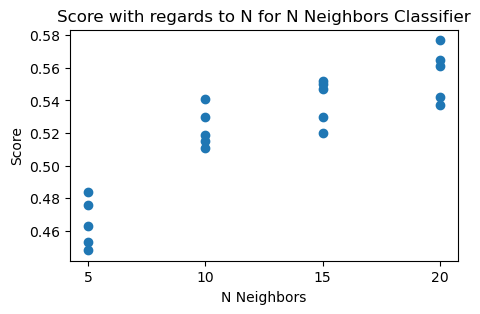

In [164]:
plt.figure(figsize=(5,3))
plt.scatter(scores[:,0], scores[:,1])
plt.xticks([5,10,15,20])
plt.xlabel("N Neighbors")
plt.ylabel("Score")
plt.title("Score with regards to N for N Neighbors Classifier")

The score increases with increase in N, but eventually plateaus after around N=20

In [121]:
with open("mbti-multiclass-kncls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

The following are the Macro F1-scores of 5-fold cross validation:

    * MultinomialNB:          0.4126
    * Logistic Regression:    0.5149 <==
    * Random Forest:          0.5034 <==
    * XGBoost:                0.5273 (weights were not stored)
    * Stochastic GD:          0.5131 <==
    * Support Vector:         0.4605
    * K-Neighbors:            0.2805

We see that the performance of the models is not upto par.

The marked classifiers have a higher f1-score compared to the rest, therefore they are used to create a voting based ensemble. Ensembles are used to lower the overall bias of the algorithm. We implement ensemble through hard voting, meaning each estimator in the ensemble gets a vote, and class with maximum votes is taken as the prediction.

# Ensemble of Multiclass Estimators

In [456]:
class MCVotingClassifier():
    def __init__(self, estimators):
        self.estimators_ = estimators
    
    def predict(self, X):
        X = np.squeeze(np.array(X))
        predictions = []
        for est in self.estimators_:
            predictions.append(est[1].predict(X=X))
        predictions = np.stack(predictions)
        
        voted_mat = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)),axis=0,arr=predictions)

        return np.squeeze(voted_mat)

In [444]:
maj = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)),axis=0,arr=predictions)
maj

array([0, 1, 7, 8, 5], dtype=int64)

In [467]:
votecls = MCVotingClassifier(estimators=[("rf", rfcls), ("sgd", sgdcls), ("lr", lrcls)])

In [468]:
Y_pred = votecls.predict(X_test)
scores_votecls = fit_metrics(Y_test, Y_pred)

In [473]:
for key, value in scores_votecls.items():
    print(key, ": ", value)

accuracy :  0.6570605187319885
precision_micro :  0.6570605187319885
precision_macro :  0.630724102940097
precision_weighted :  0.66265913623529
recall_micro :  0.6570605187319885
recall_macro :  0.42914503857163233
recall_weighted :  0.6570605187319885
f1_micro :  0.6570605187319885
f1_macro :  0.47943234428283843
f1_weighted :  0.641030207961553


In [470]:
with open("mbti-multiclass-votecls-rf-sgd-lr-scores.pkl", "wb") as pklfile:
    pickle.dump([votecls, scores_votecls], pklfile)
    pklfile.close()

In [476]:
# Testing Random Forest on test data
Y_predt = rfcls.predict(X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.2736445382822491

In [477]:
# Testing SGD on test data
Y_predt = sgdcls.predict(X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.49558465411029906

In [478]:
# Testing Logistic Regression on test data
Y_predt = lrcls.predict(X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.47683432922702734

We see that the macro-f1 for the SGD Classifier is higher than that of the ensemble.

# Converting data from Multiclass to Multilabel Classification

### Imp Note: The pre_process_data function below works for converting raw data to multilabel, and the pre_process_data function under multiclass works for converting raw data to multiclass. Multiclass data will not work for this second section or vice-versa as the variable names are the same. 

In [551]:
class MultilabelEncoder():
    """
    - This encoder converts the personality types into 4-column label representing the four axis of MBTI personality types.
    - The transform function takes in an array or a list of personality types in String format, and return an nx4 shape matrix,
        'n' being the batch size.
    - The inverse transform takes in an nx4 matrix and returns a vector of size nx1.
    """
    def __init__(self):
        self.label_dict_ = {}
        self.group_list = [('I','E'), ('N','S'), ('T','F'), ('J','P')]
        
    def fit(self):
        for tup in self.group_list:
            for i in range(len(tup)):
                self.label_dict_[tup[i]] = i
    
    def transform(self, rawclasses:np.ndarray)->np.ndarray:
        if isinstance(rawclasses, str):
            rawclasses = np.array([rawclasses])
            
        if not (isinstance(rawclasses, np.ndarray) or isinstance(rawclasses, list)):
            raise Exception("Invalid datatype. Expect a list or array of strings.")
        
        labellist = []
        for cl in rawclasses:
            labelrow = []
            for ele in str(cl):
                labelrow.append(self.label_dict_[ele])
            labellist.append(labelrow)
        return np.array(labellist)
    
    def inverse_transform(self, labelrows:np.ndarray)->np.ndarray:
        if isinstance(labelrows, list):
            labelrows = np.array(labelrows)
        
        if not isinstance(labelrows, np.ndarray):
            raise Exception("Invalid datatype. Expect a list or array of multilabels.")
        
        if len(labelrows.shape) == 1:
            np.expand_dims(labelrows, axis=0)
            
        rawclasses = []
        for labelrow in labelrows:
            label = ""
            for i in range(len(labelrow)):
                label += self.group_list[i][labelrow[i]]
            rawclasses.append(label)
        return np.array(rawclasses)

In [552]:
lab_encoder_ml = MultilabelEncoder()
lab_encoder_ml.fit()

In [554]:
###### Run this only after running pre_process_data in multiclass section
def pre_process_data2(data):
    list_personality = []
    len_data = len(data)
    
    for row in tqdm(data.iterrows()):
        type_labelized = lab_encoder_ml.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        
    list_personality = np.array(list_personality)
    
    return list_personality

list_personality = pre_process_data(data)

8675it [00:00, 10269.86it/s]


In [555]:
from sklearn.model_selection import train_test_split
train_post, test_post, train_type, test_type = train_test_split(list_posts, list_personality, test_size = 0.2,
                                                                random_state = 42, stratify = list_personality)

**For the following experiments with MultiOutputClassifiers, the trainig was not done using k-fold cross validation, because the sklearn in-built function does not support multilabel targets.**

So instead, we have a hold-out validation set apart from the test set. The training is done on the X_train_use set and validated on X_train_hold set.

In [556]:
X_train_use, X_train_hold, Y_train_use, Y_train_hold = train_test_split(train_post, train_type, test_size = 0.2,
                                                                random_state = 42, stratify = train_type)

In [557]:
X_train_use = vectorizer.transform(X_train_use).toarray()
X_train_hold = vectorizer.transform(X_train_hold).toarray()
X_test = vectorizer.transform(test_post).toarray()
Y_train_use = np.array(Y_train_use)
Y_train_hold = np.array(Y_train_hold)
Y_test = np.array(test_type)

In [558]:
print(X_train_use.shape, X_train_hold.shape, type(X_train), Y_train_use.shape, Y_train_hold.shape, type(Y_train))

(5552, 796) (1388, 796) <class 'numpy.ndarray'> (5552, 4) (1388, 4) <class 'numpy.ndarray'>


# GaussianNB

In [560]:
from sklearn.naive_bayes import GaussianNB

In [561]:
gnbcls = MultiOutputClassifier(GaussianNB(), n_jobs=-1)
gnbcls.fit(X_train_use, Y_train_use)

MultiOutputClassifier(estimator=GaussianNB(), n_jobs=-1)

In [562]:
Y_pred = gnbcls.predict(X_train_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

In [563]:
print(scores["accuracy"])

0.38328530259365995


In [564]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.6949421637559539
F1 macro : 0.6400478302555361
F1 weighted : 0.7090675359248617


In [565]:
with open("mbti-multilabel-gnbcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Logistic Regression

In [566]:
from sklearn.linear_model import LogisticRegression

In [567]:
%%time
lrcls_ml = MultiOutputClassifier(LogisticRegression(max_iter=3000), n_jobs=-1)
lrcls_ml.fit(X_train_use, Y_train_use)

CPU times: total: 46.9 ms
Wall time: 952 ms


MultiOutputClassifier(estimator=LogisticRegression(max_iter=3000), n_jobs=-1)

In [568]:
Y_pred = lrcls_ml.predict(X_train_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

In [569]:
print(scores["accuracy"])

0.55835734870317


In [570]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7837837837837838
F1 macro : 0.664685769486409
F1 weighted : 0.7641657411327551


In [571]:
with open("mbti-multilabel-lrcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Random Forest Classifier

In [572]:
from sklearn.ensemble import RandomForestClassifier

In [573]:
%%time
rfcls_ml_params = {"max_depth":14, "max_features":'sqrt', "min_samples_leaf":1,
                               "min_samples_split":2, "n_estimators":200, "random_state":42}
rfcls_ml = MultiOutputClassifier(RandomForestClassifier(**rfcls_ml_params), n_jobs=-1)
rfcls_ml.fit(X_train_use, Y_train_use)

CPU times: total: 203 ms
Wall time: 7.53 s


MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=14,
                                                       n_estimators=200,
                                                       random_state=42),
                      n_jobs=-1)

In [574]:
Y_pred = rfcls_ml.predict(X_train_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

In [575]:
print(scores["accuracy"])

0.45821325648414984


In [576]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7317791411042944
F1 macro : 0.4514217169786311
F1 weighted : 0.6499023749465032


In [577]:
with open("mbti-multilabel-rfcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Stochastic Gradient Descent Classifier

In [578]:
from sklearn.linear_model import SGDClassifier

In [579]:
%%time
sgdcls_ml_params = {"loss": "log_loss", "max_iter": 40, "learning_rate": "optimal", "tol": None, "random_state": 42}
sgdcls_ml = MultiOutputClassifier(SGDClassifier(**sgdcls_ml_params), n_jobs=-1)
sgdcls_ml.fit(X_train_use, Y_train_use)

CPU times: total: 62.5 ms
Wall time: 798 ms


MultiOutputClassifier(estimator=SGDClassifier(loss='log_loss', max_iter=40,
                                              random_state=42, tol=None),
                      n_jobs=-1)

In [580]:
Y_pred = sgdcls_ml.predict(X_train_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

In [581]:
print(scores["accuracy"])

0.5626801152737753


In [582]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7852668504134303
F1 macro : 0.6806626182807325
F1 weighted : 0.7703128572009793


In [583]:
with open("mbti-multilabel-sgdcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Support Vector Classifier

In [584]:
from sklearn.svm import SVC

In [585]:
svcls_ml = MultiOutputClassifier(SVC(random_state=42), n_jobs=-1)
svcls_ml.fit(X_train_use, Y_train_use)

MultiOutputClassifier(estimator=SVC(random_state=42), n_jobs=-1)

In [586]:
Y_pred = svcls_ml.predict(X_train_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

In [587]:
print(scores["accuracy"])

0.5612391930835735


In [588]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7868525896414342
F1 macro : 0.670874865777944
F1 weighted : 0.7681935633381846


In [589]:
with open("mbti-multilabel-svcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# K-Neighbors Classifier

In [590]:
from sklearn.neighbors import KNeighborsClassifier

In [591]:
kncls_ml = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=20), n_jobs=-1)
kncls_ml.fit(X_train_use, Y_train_use)

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=20), n_jobs=-1)

In [592]:
Y_pred = kncls_ml.predict(X_train_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

In [593]:
print(scores["accuracy"])

0.5057636887608069


In [594]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7496917385943279
F1 macro : 0.6157165718388407
F1 weighted : 0.7224879164268738


In [595]:
with open("mbti-multilabel-kncls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

The following are the Macro F1-scores:

    * GaussianNB:                0.6400
    * Logistic Regression:       0.6646 <==
    * Random Forest:             0.4514 
    * XGBoost:                    --- (was not trained, since the dimensionality is high, so takes a lot of training time)
    * Stochastic GD:             0.6806 <==
    * Support Vector:            0.6708 <==
    * K-Neighbors:               0.6157

Here we see that the f1-score in general has improved, by around 15%.

The marked classifiers have a higher f1-score compared to the rest, therefore they are used to create a voting based ensemble.

# Ensemble of Multilabel Estimators

In [597]:
class MLVotingClassifier():
    def __init__(self, estimators):
        self.estimators_ = estimators
    
    def predict(self, X):
        X = np.squeeze(np.array(X))
        predictions = []
        for est in self.estimators_:
            predictions.append(est[1].predict(X))
        predictions = np.stack(predictions)
        
        voted_mat = np.round(np.sum(predictions, axis=0)/len(self.estimators_))

        return np.squeeze(voted_mat)

In [598]:
votecls_ml = MLVotingClassifier(estimators=[("svc", svcls_ml), ("sgd", sgdcls_ml), ("lr", lrcls_ml)])

In [599]:
Y_pred = votecls_ml.predict(X_test)
scores_votecls_ml = fit_metrics(test_type, Y_pred)

In [600]:
for key, value in scores_votecls_ml.items():
    print(key, ": ", value)

accuracy :  0.5602305475504322
precision_micro :  0.8194616977225673
precision_macro :  0.7905812441319737
precision_weighted :  0.811974267163862
recall_micro :  0.7530441400304414
recall_macro :  0.6263318966189222
recall_weighted :  0.7530441400304414
f1_micro :  0.7848502875272655
f1_macro :  0.6776852074160951
f1_weighted :  0.7687713842597848


In [601]:
with open("mbti-multilabel-votecls-svc-sgd-lr-scores.pkl", "wb") as pklfile:
    pickle.dump([votecls_ml, scores_votecls_ml], pklfile)
    pklfile.close()

In [602]:
# Testing SVC on test data
Y_predt = svcls_ml.predict(X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.6719043116989276

In [603]:
# Testing SGC on test data
Y_predt = sgdcls_ml.predict(X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.6858838234189114

In [604]:
# Testing Logistic Regression on test data
Y_predt = lrcls_ml.predict(X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.6637047484106884

Here we see that the SGD classifier scores better than the ensemble and Logistic Regression scores worse, while SVC is on par with the ensemble.

# PCA Decomposition

We perform PCA on our feature set, which is a 796d vector. We vary n_components to see which would be the most suitable. The reduced dimensionality will enable us to train the XGBoost Classifier.

In [605]:
from sklearn.decomposition import PCA

In [290]:
f1_macros = []
ncomps = [10,15,20,25]
for n in ncomps:
    pca = PCA(n_components = n, random_state = 42)
    pca_X_use = pca.fit_transform(X_train_use)
    pca_X_hold = pca.transform(X_train_hold)
    pcamodeltest = MultiOutputClassifier(LogisticRegression(max_iter=3000), n_jobs=-1)
    pcamodeltest.fit(pca_X_use, Y_train_use)
    Y_pred = pcamodeltest.predict(pca_X_hold)
    scores = fit_metrics(Y_train_hold, Y_pred)

    print()
    print("Accuracy @PCA=%d:" %n, scores["accuracy"])
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            f1_macros.append(scores["f1_"+metric])
        print("F1 "+metric,":", scores["f1_"+metric])


Accuracy @PCA=10: 0.5295389048991355
F1 micro : 0.7600997506234415
F1 macro : 0.5796724172517771
F1 weighted : 0.723660852151896

Accuracy @PCA=15: 0.5554755043227666
F1 micro : 0.7748821047406305
F1 macro : 0.631209804796296
F1 weighted : 0.7479183962442661

Accuracy @PCA=20: 0.5504322766570605
F1 micro : 0.7777222777222778
F1 macro : 0.6375941261823029
F1 weighted : 0.7519048529389285

Accuracy @PCA=25: 0.5619596541786743
F1 micro : 0.782565130260521
F1 macro : 0.6485827906286449
F1 weighted : 0.7584714029309846


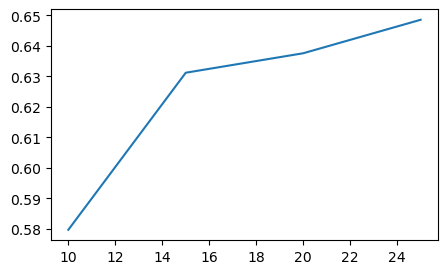

In [291]:
plt.figure(figsize=(5,3))
plt.plot(ncomps, f1_macros)

We see that the gain in information as the number of components increase starts to flatten after around 24-25, i.e., the gain in information wrt the increase in complexity (dimensionality) becomes low.

## PCA Data

In [606]:
pca = PCA(n_components = 25, random_state = 42)
pca_X_use = pca.fit_transform(X_train_use)
pca_X_hold = pca.transform(X_train_hold)

# Random Forest Classifier

In [607]:
from sklearn.ensemble import RandomForestClassifier

In [610]:
%%time
rfcls_ml_pca_params = {"max_depth":14, "max_features":'sqrt', "min_samples_leaf":1,
                               "min_samples_split":2, "n_estimators":200, "random_state":42}
rfcls_ml_pca = MultiOutputClassifier(RandomForestClassifier(**rfcls_ml_pca_params), n_jobs=-1)
rfcls_ml_pca.fit(pca_X_use, Y_train_use)

Y_pred = rfcls_ml_pca.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 703 ms
Wall time: 5.9 s


In [611]:
print(scores["accuracy"])

0.5857348703170029


In [612]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7881918819188192
F1 macro : 0.6830028740935671
F1 weighted : 0.7707801522633511


In [613]:
with open("mbti-multilabel-rfcls-pca-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Random Forest Classifier (n estimators = 400)

In [614]:
from sklearn.ensemble import RandomForestClassifier

In [615]:
%%time
rfcls_ml_pca_nest400_params = {"max_depth":14, "max_features":'sqrt', "min_samples_leaf":1,
                               "min_samples_split":2, "n_estimators":400, "random_state":42}
rfcls_ml_pca_nest400 = MultiOutputClassifier(RandomForestClassifier(**rfcls_ml_pca_nest400_params), n_jobs=-1)
rfcls_ml_pca_nest400.fit(pca_X_use, Y_train_use)

Y_pred = rfcls_ml_pca_nest400.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 1.66 s
Wall time: 9.45 s


In [616]:
print(scores["accuracy"])

0.595821325648415


In [617]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.790720631786772
F1 macro : 0.6824603635543727
F1 weighted : 0.7729452903352263


In [618]:
with open("mbti-multilabel-rfcls-pca-nest400-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Random Forest Classifier (max depth=20)

In [619]:
from sklearn.ensemble import RandomForestClassifier

In [620]:
%%time
rfcls_ml_pca_mxdp20_params = {"max_depth":20, "max_features":'sqrt', "min_samples_leaf":1,
                               "min_samples_split":2, "n_estimators":200, "random_state":42}
rfcls_ml_pca_mxdp20 = MultiOutputClassifier(RandomForestClassifier(**rfcls_ml_pca_mxdp20_params), n_jobs=-1)
rfcls_ml_pca_mxdp20.fit(pca_X_use, Y_train_use)

Y_pred = rfcls_ml_pca_mxdp20.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 875 ms
Wall time: 5.51 s


In [621]:
print(scores["accuracy"])

0.5893371757925072


In [622]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7895386133728103
F1 macro : 0.6870201563993609
F1 weighted : 0.7728592311737583


In [623]:
with open("mbti-multilabel-rfcls-pca-mxdp20-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# XGBoostClassifier

In [624]:
from xgboost import XGBClassifier

In [625]:
%%time
xgbcls_ml_pca_params = {"n_estimators": 100, "max_depth": 4, "learning_rate": 0.1, "random_state": 42}
xgbcls_ml_pca = MultiOutputClassifier(XGBClassifier(**xgbcls_ml_pca_params), n_jobs=-1)
xgbcls_ml_pca.fit(pca_X_use, Y_train_use)

Y_pred = xgbcls_ml_pca.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 2.67 s
Wall time: 3.01 s


In [626]:
print(scores["accuracy"])

0.6073487031700289


In [627]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.8003947693066863
F1 macro : 0.7293618136774231
F1 weighted : 0.7916257882175033


In [628]:
with open("mbti-multilabel-xgbcls-pca-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# XGBoostClassifier (n estimators = 200)

In [629]:
from xgboost import XGBClassifier

In [630]:
%%time
xgbcls_ml_pca_nest200_params = {"n_estimators": 200, "max_depth": 4, "learning_rate": 0.1, "random_state": 42}
xgbcls_ml_pca_nest200 = MultiOutputClassifier(XGBClassifier(**xgbcls_ml_pca_nest200_params), n_jobs=-1)
xgbcls_ml_pca_nest200.fit(pca_X_use, Y_train_use)

Y_pred = xgbcls_ml_pca_nest200.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 4.03 s
Wall time: 4.83 s


In [631]:
print(scores["accuracy"])

0.6087896253602305


In [632]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.8006881297616122
F1 macro : 0.7337386336850347
F1 weighted : 0.7932835201199974


In [633]:
with open("mbti-multilabel-xgbcls-pca-nest200-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# XGBoostClassifier (n estimators = 200, max depth = 8)

In [634]:
from xgboost import XGBClassifier

In [635]:
%%time
xgbcls_ml_pca_nest200_mxdp8_params = {"n_estimators": 200, "max_depth": 8, "learning_rate": 0.1, "random_state": 42}
xgbcls_ml_pca_nest200_mxdp8 = MultiOutputClassifier(XGBClassifier(**xgbcls_ml_pca_nest200_mxdp8_params), n_jobs=-1)
xgbcls_ml_pca_nest200_mxdp8.fit(pca_X_use, Y_train_use)

Y_pred = xgbcls_ml_pca_nest200_mxdp8.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 3.14 s
Wall time: 7.96 s


In [636]:
print(scores["accuracy"])

0.6015850144092219


In [637]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7975550122249387
F1 macro : 0.7219004501790213
F1 weighted : 0.7890441390814489


In [638]:
with open("mbti-multilabel-xgbcls-pca-nest200-mxdp8-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Stochastic Gradient Descent Classifier

In [649]:
from sklearn.linear_model import SGDClassifier

In [650]:
%%time
sgdcls_ml_pca_params = {"loss": "log_loss", "max_iter": 40, "learning_rate": "optimal", "tol": None, "random_state": 42}
sgdcls_ml_pca = MultiOutputClassifier(SGDClassifier(**sgdcls_ml_pca_params), n_jobs=-1)
sgdcls_ml_pca.fit(X_train_use, Y_train_use)

CPU times: total: 172 ms
Wall time: 3.76 s


MultiOutputClassifier(estimator=SGDClassifier(loss='log_loss', max_iter=40,
                                              random_state=42, tol=None),
                      n_jobs=-1)

In [651]:
Y_pred = sgdcls_ml_pca.predict(X_train_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

In [652]:
print(scores["accuracy"])

0.5626801152737753


In [653]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7852668504134303
F1 macro : 0.6806626182807325
F1 weighted : 0.7703128572009793


In [583]:
with open("mbti-multilabel-sgdcls-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# Support Vector Classifier

In [639]:
from sklearn.svm import SVC

In [640]:
%%time
svcls_ml_pca = MultiOutputClassifier(SVC(random_state=42), n_jobs=-1)
svcls_ml_pca.fit(pca_X_use, Y_train_use)

Y_pred = svcls_ml_pca.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 156 ms
Wall time: 3.58 s


In [641]:
print(scores["accuracy"])

0.6188760806916427


In [642]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.8105986261040237
F1 macro : 0.7385379226206856
F1 weighted : 0.8012816461963909


In [643]:
with open("mbti-multilabel-svcls-pca-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

# K-Neighbors Classifier

In [644]:
from sklearn.neighbors import KNeighborsClassifier

In [329]:
f1_macros = []
nnbors = [8,10,12,14,16,18,20,22,25,30,35]
for n in nnbors:
    pcamodeltest = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=n), n_jobs=-1)
    pcamodeltest.fit(pca_X_use, Y_train_use)
    Y_pred = pcamodeltest.predict(pca_X_hold)
    scores = fit_metrics(Y_train_hold, Y_pred)

    print()
    print("Accuracy @NNeighbors=%d:" %n, scores["accuracy"])
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            f1_macros.append(scores["f1_"+metric])
        print("F1 "+metric,":", scores["f1_"+metric])


Accuracy @NNeighbors=8: 0.5417867435158501
F1 micro : 0.7468256024876913
F1 macro : 0.6428226756348643
F1 weighted : 0.7301640675604067

Accuracy @NNeighbors=10: 0.537463976945245
F1 micro : 0.748712667353244
F1 macro : 0.6450465493486347
F1 weighted : 0.7314852886248843

Accuracy @NNeighbors=12: 0.5497118155619597
F1 micro : 0.7551909766726481
F1 macro : 0.6490270390576405
F1 weighted : 0.7370709908935048

Accuracy @NNeighbors=14: 0.5540345821325648
F1 micro : 0.7610529005877842
F1 macro : 0.656573859577689
F1 weighted : 0.7433140185245399

Accuracy @NNeighbors=16: 0.5597982708933718
F1 micro : 0.760183299389002
F1 macro : 0.6525768825169324
F1 weighted : 0.7418059292077115

Accuracy @NNeighbors=18: 0.5547550432276657
F1 micro : 0.760284408329101
F1 macro : 0.6469932526008119
F1 weighted : 0.7403962397771553

Accuracy @NNeighbors=20: 0.5590778097982709
F1 micro : 0.7640050697084917
F1 macro : 0.6474381203255676
F1 weighted : 0.7427972677380431

Accuracy @NNeighbors=22: 0.564841498559

In [331]:
nnbors2 = [40,45,50,55]
# pca = PCA(n_components = 25)
# pca_X_use = pca.fit_transform(X_train_use)
# pca_X_hold = pca.transform(X_train_hold)
for n in nnbors2:
    pcamodeltest = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=n), n_jobs=-1)
    pcamodeltest.fit(pca_X_use, Y_train_use)
    Y_pred = pcamodeltest.predict(pca_X_hold)
    scores = fit_metrics(Y_train_hold, Y_pred)

    print()
    print("Accuracy @NNeighbors=%d:" %n, scores["accuracy"])
    for metric in ["micro", "macro", "weighted"]:
        if metric == "macro":
            f1_macros.append(scores["f1_"+metric])
        print("F1 "+metric,":", scores["f1_"+metric])


Accuracy @NNeighbors=40: 0.5597982708933718
F1 micro : 0.7681451612903225
F1 macro : 0.6406480782745613
F1 weighted : 0.7431730710680645

Accuracy @NNeighbors=45: 0.5590778097982709
F1 micro : 0.7689233075193604
F1 macro : 0.6394324803932445
F1 weighted : 0.7428952407233075

Accuracy @NNeighbors=50: 0.5597982708933718
F1 micro : 0.7673716012084593
F1 macro : 0.6351221094460885
F1 weighted : 0.7404716173817637

Accuracy @NNeighbors=55: 0.5525936599423631
F1 micro : 0.7676566009483404
F1 macro : 0.6290751587846042
F1 weighted : 0.7388851308702505


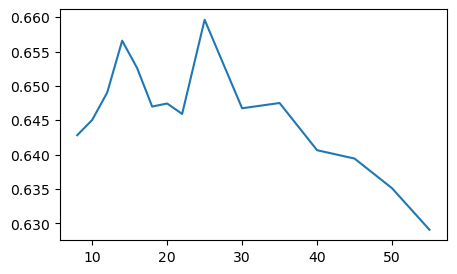

In [333]:
plt.figure(figsize=(5,3))
plt.plot(nnbors+nnbors2, f1_macros)

In [645]:
%%time
kncls_ml_pca = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=15), n_jobs=-1)
kncls_ml_pca.fit(pca_X_use, Y_train_use)

Y_pred = kncls_ml_pca.predict(pca_X_hold)
scores = fit_metrics(Y_train_hold, Y_pred)

CPU times: total: 188 ms
Wall time: 505 ms


In [646]:
print(scores["accuracy"])

0.5677233429394812


In [647]:
for metric in ["micro", "macro", "weighted"]:
    print("F1 "+metric,":", scores["f1_"+metric])

F1 micro : 0.7724000992802182
F1 macro : 0.6702317113040601
F1 weighted : 0.7548464187363768


In [648]:
with open("mbti-multilabel-kncls-pca-scores.pkl", "wb") as pklfile:
    pickle.dump(scores, pklfile)
    pklfile.close()

The following are the Macro F1-scores:

    * Random Forest:                                                     0.6830 
    * Random Forest Classifier (n estimators = 400):                     0.6824
    * Random Forest Classifier (max depth=20):                           0.6870 <==
    * XGBoost:                                                           0.7293
    * XGBoostClassifier (n estimators = 200):                            0.7337 <==
    * XGBoostClassifier (n estimators = 200, max depth = 8):             0.7219
    * SGD Classifier:                                                    0.6806
    * Support Vector Classifier:                                         0.7385 <==
    * K-Neighbors Classifier:                                            0.6702

Here we see that the f1-score has further improved, by around 1.5 - 2.0%.

The marked classifiers have a higher f1-score compared to the rest, therefore they are used to create a voting based ensemble.

# Ensemble of Multilabel Estimators following PCA

In [654]:
from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder_mc = LabelEncoder().fit(unique_type_list)

In [655]:
class MLVotingClassifier():
    def __init__(self, estimators):
        self.estimators_ = estimators
    
    def predict(self, X):
        X = np.squeeze(np.array(X))
        predictions = []
        for est in self.estimators_:
            predictions.append(est[1].predict(X))
        predictions = np.stack(predictions)
        
        voted_mat = np.round(np.sum(predictions, axis=0)/len(self.estimators_))

        return np.squeeze(voted_mat)

In [657]:
votecls_ml_pca = MLVotingClassifier(estimators=[("xgb", xgbcls_ml_pca_nest200), ("svc", svcls_ml_pca), ("rf", rfcls_ml_pca_mxdp20)])

In [658]:
%%time
pca_X_test = pca.transform(X_test)
pca_X_train = pca.transform(X_train)

Y_pred = votecls_ml_pca.predict(pca_X_test)

CPU times: total: 2.38 s
Wall time: 3.2 s


In [659]:
scores_votecls_ml_pca = fit_metrics(Y_test, Y_pred)

In [660]:
for key, value in scores_votecls_ml_pca.items():
    print(key, ": ", value)

accuracy :  0.5948126801152738
precision_micro :  0.8238659583163057
precision_macro :  0.8011979943363301
precision_weighted :  0.818536899205262
recall_micro :  0.7671232876712328
recall_macro :  0.6485473374902986
recall_weighted :  0.7671232876712328
f1_micro :  0.7944827586206897
f1_macro :  0.6983915047416918
f1_weighted :  0.7810382526261969


In [661]:
with open("mbti-multilabel-votecls-pca-xgb-svc-rf-scores.pkl", "wb") as pklfile:
    pickle.dump([votecls_ml_pca, scores_votecls_ml_pca], pklfile)
    pklfile.close()

In [665]:
# Testing XGB on test data
Y_predt = xgbcls_ml_pca_nest200.predict(pca_X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.7055346040896263

In [666]:
for key, value in scorest.items():
    print(key, ": ", value)

accuracy :  0.5844380403458214
precision_micro :  0.8157358336730534
precision_macro :  0.7807597583767538
precision_weighted :  0.8089185885240212
recall_micro :  0.7614155251141552
recall_macro :  0.6596852596460665
recall_weighted :  0.7614155251141552
f1_micro :  0.7876402283015154
f1_macro :  0.7055346040896263
f1_weighted :  0.7783243484998205


In [667]:
# Testing SVC on test data
Y_predt = svcls_ml_pca.predict(pca_X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.7178015496462118

In [668]:
for key, value in scorest.items():
    print(key, ": ", value)

accuracy :  0.6144092219020173
precision_micro :  0.8264363198071515
precision_macro :  0.800537263215578
precision_weighted :  0.8210280180827091
recall_micro :  0.782724505327245
recall_macro :  0.6730739913623497
recall_weighted :  0.782724505327245
f1_micro :  0.8039867109634551
f1_macro :  0.7178015496462118
f1_weighted :  0.793132400760721


In [664]:
# Testing RF on test data
Y_predt = rfcls_ml_pca_mxdp20.predict(pca_X_test)
scorest = fit_metrics(Y_test, Y_predt)
scorest["f1_macro"]

0.66816019118049

Here we find that the Support Vector Classifier outperforms the other estimators as well as Ensemble model.
The testset scores of the SVC Classifier using PCA is enumerated below:

In [678]:
rownames = ["precision", "f1", "recall"]
colnames = ["micro", "macro", "weighted"]
scoremat = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        scoremat[i][j] = scorest[rownames[i]+"_"+colnames[j]]*100

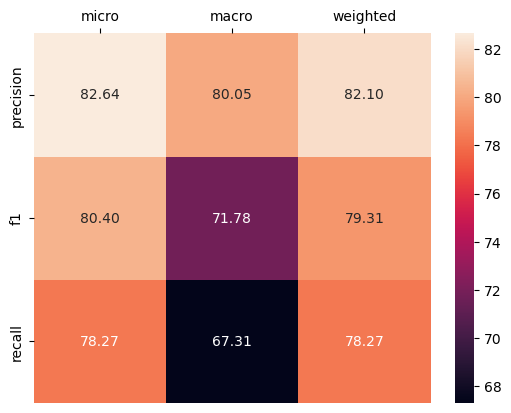

In [680]:
ax = sns.heatmap(scoremat, annot=True, xticklabels=colnames, yticklabels=rownames, fmt=".2f")
ax.xaxis.tick_top()

    Precision: All three precision scores are relatively high, so the model will have a lower number of false positives.
    
    F1: The micro and weighted F1-scores are relatively high, however the macro F1 is on the lower side, indicating class imbalance.
    
    Recall: The micro and weighted recall is relatively high as compared to macro recall which is low, meaning due to class imbalance, there are certain instances for which the classes are actually positive, which will fail to get identified, i.e., the false negatives will increase. This can be problematic for real-world deployments where the input distribution of data might not match the data on which it was trained on.
    
    Accuracy: 71.78%

# Future Work

Future work may include:

    * Lemmatizing words to get a more concise vocabulary, which will add to the information contained in the feature sets, thus improving model performance.
    * Use GloVe embedding to get vectors of words in the vocabulary and use them to train sequence models like LSTM and other models like CNN. (A topic of study)
    * Hyperparameter tuning of the top estimators may lead to an increase in model_performance.